In [1]:
import numpy as np

from astropy.io import fits
from astropy import wcs

from jwst import datamodels
from jwst.assign_wcs import nirspec

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['image.origin'] = 'lower'

In [3]:
im = datamodels.ImageModel('ALLSLITS_assign_wcs.fits')

In [4]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res

### Compare in full frame coordinates - wcs.get_transform('sca', 'world')

In [5]:
trace = "ALLSLITS_Trace_SLIT_A_200_1_V84600002001P0000000002101_39520_JLAB88.fits"
tr = fits.open(trace)
#tr.info()
lam1 = tr['LAMBDA1'].data
slit1 = tr['SLITY1'].data
pyw = wcs.WCS(tr['LAMBDA1'].header)
slice_id = "S200A1"
tr.close()

# Create x, y indices using the Trace WCS
y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
x1, y1 = pyw.all_pix2world(x, y, 0)

['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'world']


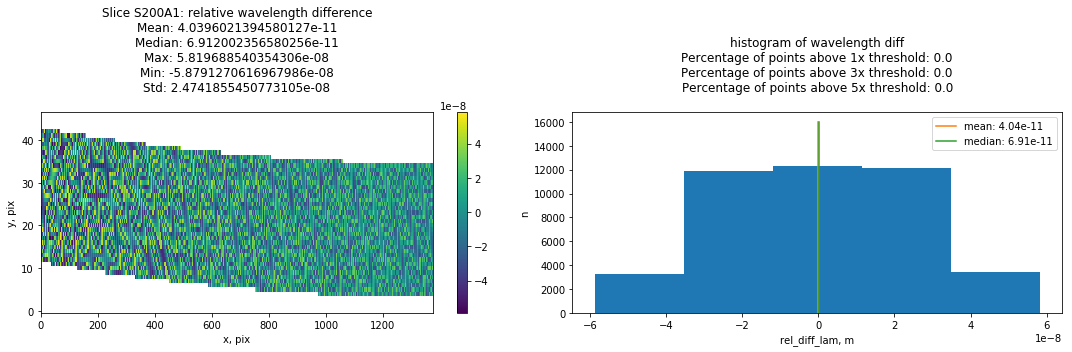

In [6]:
# Get the WCS for this particular slice
wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)

# Get the transfrom from SCA (in full frame coordinates) to world
print(wcs_slice.available_frames)
sca2world = wcs_slice.get_transform('sca', 'world')
# Compute ra, dec and lambda
ra, dec, lam = sca2world(x1-1, y1-1)
lam *= 10**-6

# Compute indices for slit-y between -.5 and .5
in_slit = np.logical_and(slit1<.5, slit1>-.5)
lam[~in_slit] = np.nan
nanind = np.isnan(lam)
notnan = ~nanind
# Set lam values outside the slit to NaN
lam1[nanind] = np.nan

# Compute the difference in wavelength
rel_diff_lam = (lam1 - lam) / lam1

# Compute statistics for notnan indices
mean = np.mean(rel_diff_lam[notnan])
median = np.median(rel_diff_lam[notnan])
dmax = np.max(rel_diff_lam[notnan])
dmin = np.min(rel_diff_lam[notnan])
dstd = np.std(rel_diff_lam[notnan])
percentage_results = compute_percentage(rel_diff_lam, 1e-7)

title1 = "Slice {}: relative wavelength difference\n".format(slice_id)
title1 += "Mean: {}\n".format(mean)
title1 += "Median: {}\n".format(median)
title1 += "Max: {}\n".format(dmax)
title1 += "Min: {}\n".format(dmin)
title1 += "Std: {}\n".format(dstd)

title2 = "histogram of wavelength diff\n"
title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,2,1)
i1 = ax1.imshow(rel_diff_lam, aspect='auto')
plt.title(title1)
plt.colorbar(i1, ax=ax1 )
plt.xlabel('x, pix')
plt.ylabel('y, pix')
ax2 = plt.subplot(1,2,2)
i2 = plt.hist(rel_diff_lam[~np.isnan(rel_diff_lam)].flatten(), bins=5)
ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
ax2.legend()
plt.title(title2)
plt.xlabel('rel_diff_lam, m')
plt.ylabel('n')
fig.tight_layout()

### Comparison in subarray coordinates

In [7]:
print(im.meta.subarray._instance)

{'fastaxis': 2, 'name': 'ALLSLITS', 'slowaxis': 1, 'xsize': 2048, 'xstart': 1, 'ysize': 256, 'ystart': 897}


Since `ystart=897`, correct the full frame coordinates with this value

In [8]:
xstart, ystart = im.meta.subarray.xstart, im.meta.subarray.ystart
y2 = y1 - (ystart-1)
x2 = x1 - (xstart-1)

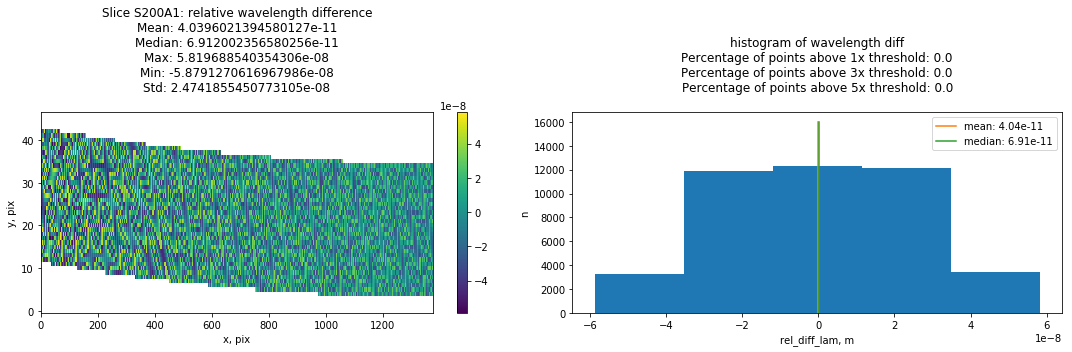

In [9]:
# Compute ra, dec and lambda
ra, dec, lam = wcs_slice(x2-1, y2-1, with_bounding_box=False)
lam *= 10**-6

# Compute indices for slit-y between -.5 and .5
in_slit = np.logical_and(slit1<.5, slit1>-.5)
lam[~in_slit] = np.nan
nanind = np.isnan(lam)
notnan = ~nanind
# Set lam values outside the slit to NaN
lam1[nanind] = np.nan

# Compute the difference in wavelength
rel_diff_lam = (lam1 - lam) / lam1

# Compute statistics for notnan indices
mean = np.mean(rel_diff_lam[notnan])
median = np.median(rel_diff_lam[notnan])
dmax = np.max(rel_diff_lam[notnan])
dmin = np.min(rel_diff_lam[notnan])
dstd = np.std(rel_diff_lam[notnan])
percentage_results = compute_percentage(rel_diff_lam, 1e-7)

title1 = "Slice {}: relative wavelength difference\n".format(slice_id)
title1 += "Mean: {}\n".format(mean)
title1 += "Median: {}\n".format(median)
title1 += "Max: {}\n".format(dmax)
title1 += "Min: {}\n".format(dmin)
title1 += "Std: {}\n".format(dstd)

title2 = "histogram of wavelength diff\n"
title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])

fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1,2,1)
i1 = ax1.imshow(rel_diff_lam, aspect='auto')
plt.title(title1)
plt.colorbar(i1, ax=ax1 )
plt.xlabel('x, pix')
plt.ylabel('y, pix')
ax2 = plt.subplot(1,2,2)
i2 = plt.hist(rel_diff_lam[~np.isnan(rel_diff_lam)].flatten(), bins=5)
ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
ax2.legend()
plt.title(title2)
plt.xlabel('rel_diff_lam, m')
plt.ylabel('n')
fig.tight_layout()

### Plot the original data

Since this is the ALLSLIT subarray the dimensions are (2048, 256).

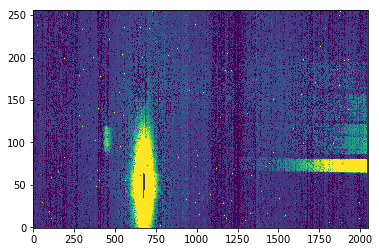

In [10]:
data = im.data
#plt.gray()
plt.imshow(data, aspect='auto', vmin=-0.5, vmax=2.9)

The transforms are such that if a user takes screen coordinates and runs them through the WCS they will get correct results (currently if they pass `with_bounding_box=False` when they evaluate the WCS transforms).

The individual slice WCS objects have bounding boxes which hold the individual slice only. And so if the WCS is evaluated using the default call (wcs(x, y, with_bounding_box=True) most values will be rejected as lying outside the bounding box of a slice. The result is :

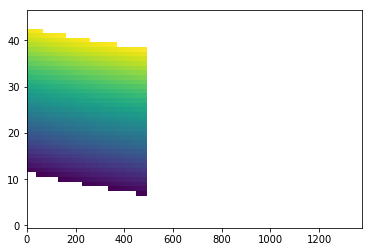

In [11]:
ra_slice, dec_slice, lam_slice = wcs_slice(x2-1, y2-1)
plt.imshow(ra_slice, aspect='auto')